In [7]:
# Step 1: Clone the specific branch hackathon-prep
!git clone --branch hackathon-prep https://github.com/adamimos/epsilon-transformers.git
%cd epsilon-transformers

# Step 2: Install the necessary dependencies
!pip install -e .

# Step 3: Install gdown if not already installed
#!pip install gdown

# Step 4: Download the RRXOR experiment data
#!gdown "https://drive.google.com/uc?id=1PYMcdvvJ_FW31rQDBmnNKz9LOyFEcfqQ" -O vfs4q106-rrxor.zip

# Step 5: Unzip the data in the correct location
#!unzip vfs4q106-rrxor.zip -d examples/models/


Cloning into 'epsilon-transformers'...
remote: Enumerating objects: 5666, done.
remote: Counting objects: 100% (1049/1049), done.
remote: Compressing objects: 100% (506/506), done.
remote: Total 5666 (delta 554), reused 889 (delta 527), pack-reused 4617
Receiving objects: 100% (5666/5666), 242.68 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (3191/3191), done.
/content/epsilon-transformers
Obtaining file:///content/epsilon-transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached wandb-0.17.0-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.7 MB)
  Using cached transformer_lens-2.0.0-py3-none-any.whl (144 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 58.1 MB/s eta 0:

In [8]:
from epsilon_transformers.process.processes import ZeroOneR, GoldenMean, Mess3

proc1 = ZeroOneR()
proc2 = GoldenMean(1,1)

print(proc1.transition_matrix)
print(proc2.transition_matrix)
print(proc1.vocab_len)
print(type(proc1.transition_matrix))


[[[0.  1.  0. ]
  [0.  0.  0. ]
  [0.5 0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  1. ]
  [0.5 0.  0. ]]]
[[[0.5 0. ]
  [1.  0. ]]

 [[0.  0.5]
  [0.  0. ]]]
2
<class 'numpy.ndarray'>


(3, 1, 1)
[[[0.5  0.  ]
  [0.   0.25]]

 [[0.25 0.  ]
  [0.   0.5 ]]

 [[0.25 0.  ]
  [0.   0.25]]]
(3, 2, 2)
[[[0.5  0.   0.  ]
  [0.   0.25 0.  ]
  [0.   0.   0.25]]

 [[0.25 0.   0.  ]
  [0.   0.5  0.  ]
  [0.   0.   0.25]]

 [[0.25 0.   0.  ]
  [0.   0.25 0.  ]
  [0.   0.   0.5 ]]]


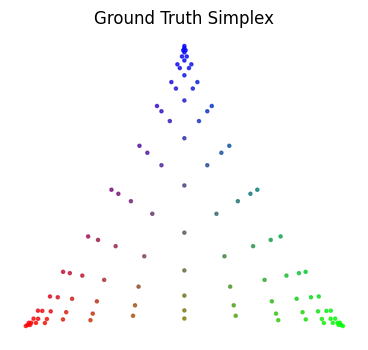

In [9]:
from epsilon_transformers.process.Process import Process
import numpy as np

class GluedProcess(Process):
    def __init__(self, proc1, proc2, join_on=dict(), weights=(0.5,0.5)):
        # join_on is a dictionary that maps vocubulary from Process 2 to Process 1
        # So join_on = {0: 1} means that emitting a "0" in Process 2 looks the same
        # as emitting a "1" in Process 1, but all other vocubulary of Process 1
        # is discernable.

        self.name = proc1.name + "+" + proc2.name
        self.proc1 = proc1
        self.proc2 = proc2
        self.weights = weights
        self.join_on = join_on
        super().__init__()

    def _create_hmm(self):
        n_states = len(self.proc1.state_names_dict)
        state_names = self.proc1.state_names_dict.copy()
        for key, val in self.proc2.state_names_dict.items():
            # choose a unique name for merged state in case it is already occupied
            while key in state_names:
                key += "_"
            state_names[key] = n_states
            n_states += 1

        # For a combination in which the vocabulary is disjoint, the vocab
        # size is the sum, else the larger of the two
        vocab_len = self.proc1.vocab_len + self.proc2.vocab_len - len(self.join_on)
        T = np.zeros((vocab_len, n_states, n_states))

        # Copying over values from Proc1
        shape1 = self.proc1.transition_matrix.shape
        print(shape1)
        T[:shape1[0], :shape1[1], :shape1[2]] = self.proc1.transition_matrix

        # Copying from Proc2
        new_v = 0  # This counts the number of new vocabulary tokens
        for v in range(self.proc2.vocab_len):
            if v in self.join_on:
                T[self.join_on[v], shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v, :, :]
            else:
                T[shape1[0] + new_v, shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v, :, :]
                new_v += 1

        print(T)
        return T, state_names

    @property
    def steady_state_vector(self):
        steady_state_vector = np.concatenate(
            (self.proc1.steady_state_vector * self.weights[0], self.proc2.steady_state_vector * self.weights[1])
        )
        # steady_state_vector = np.ones((self.num_states))

        out = steady_state_vector / steady_state_vector.sum()
        assert out.ndim == 1
        assert len(out) == self.num_states
        return out

class D3(Process):
    def __init__(self, a, b):  # modify the fucntion name of init as __init__
        self.name = "d3"
        self.a = a
        self.b = b
        super().__init__()

    def _create_hmm(self):
        T = np.zeros((3, 1, 1))
        state_names = {"0": 0}
        T[0, state_names["0"], state_names["0"]] = self.a
        T[1, state_names["0"], state_names["0"]] = self.b
        T[2, state_names["0"], state_names["0"]] = 1 - self.a - self.b

        return T, state_names

from epsilon_transformers.visualization.plots import _project_to_simplex
import matplotlib.pyplot as plt

proc1 = D3(0.5, 0.25)
proc2 = D3(0.25, 0.5)
proc3 = D3(0.25, 0.25)
process = GluedProcess(GluedProcess(proc1, proc2, join_on={0:0, 1:1, 2:2}), proc3, join_on={0:0, 1:1, 2:2}, weights=(2, 1))

# Mixed state tree generation and plotting
mixed_state_tree = process.derive_mixed_state_presentation(depth=8)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}
ground_truth_simplex = _project_to_simplex(np.array(list(msp_belief_index.keys())))
plt.figure(figsize=(4.5, 4))
plt.scatter(ground_truth_simplex[0], ground_truth_simplex[1], c=[k for k in list(msp_belief_index.keys())], alpha=.75, s=5)
plt.title("Ground Truth Simplex")
plt.gca().set_axis_off()
plt.show()



Transformer training


In [10]:
from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns

import numpy as np
import torch
import plotly.express as px
import matplotlib.pyplot as plt
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [11]:
import torch
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
def get_transformer_data_from_process(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states
    transformer_data = [x for x in tree_paths if len(x) == n_ctx+1]
    transformer_data = torch.tensor(transformer_data)
    transformer_input = transformer_data[:, :-1]
    transformer_target = transformer_data[:, 1:]
    return transformer_input, transformer_target

def get_lower_bound_for_cross_entropy(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    myopic_entropy = mixed_state_tree.myopic_entropy
    return myopic_entropy[1:]

In [13]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 3,
    d_model = 9,
    d_head = 3,
    d_mlp = 9,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=3,
    n_ctx=8,
    init_weights=True,
    device=device,
    seed = 999,
)

In [14]:
import torch
from torch.utils.data import IterableDataset, DataLoader
from typing import List, Tuple, Iterable


class ProcessDataset(IterableDataset):

    def __init__(self, process, sequence_length, num_samples, fixed=False):
        super().__init__()
        self.process = process
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.fixed = fixed
        if self.fixed:
          self.samples = list(self._get_samples())
        else:
          self.samples = None

    def _get_samples(self):
      return process.yield_emissions(
            sequence_len=self.num_samples * (self.sequence_length + 1)
        )

    def __len__(self):
        return self.num_samples

    def __iter__(self) -> Iterable[Tuple[List[int]]]:
        samples = self._get_samples() if self.samples is None else iter(self.samples)
        for _ in range(self.num_samples):
            process_history = [
                next(samples) for _ in range(self.sequence_length + 1)
            ]
            yield (process_history[:-1], process_history[1:])


def process_dataset_collate_fn(batch: List[Tuple[List[int]]]):
    data = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    return torch.tensor(data, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


train_dataset = ProcessDataset(process, sequence_length=cfg.n_ctx, num_samples=10000,
                                     fixed=False)
train_dataloader = DataLoader(train_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)
val_dataset = ProcessDataset(process, sequence_length=cfg.n_ctx, num_samples=1000,
                                   fixed=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)

In [16]:
proc1 = D3(0.5,0.25)
proc2 = D3(0.25,0.5)
proc3 = D3(0.25,0.25)
process = GluedProcess(GluedProcess(proc1, proc2, join_on={0:0,1:1,2:2}), proc3, join_on={0:0,1:1,2:2},weights=(2,1))
transformer_inputs, transformer_targets = get_transformer_data_from_process(process, cfg.n_ctx)
minimum_loss = np.mean(get_lower_bound_for_cross_entropy(process, cfg.n_ctx))
print(f"Minimum Loss: {minimum_loss}")
transformer_inputs = transformer_inputs.to(device)
transformer_targets = transformer_targets.to(device)

(3, 1, 1)
[[[0.5  0.  ]
  [0.   0.25]]

 [[0.25 0.  ]
  [0.   0.5 ]]

 [[0.25 0.  ]
  [0.   0.25]]]
(3, 2, 2)
[[[0.5  0.   0.  ]
  [0.   0.25 0.  ]
  [0.   0.   0.25]]

 [[0.25 0.   0.  ]
  [0.   0.5  0.  ]
  [0.   0.   0.25]]

 [[0.25 0.   0.  ]
  [0.   0.25 0.  ]
  [0.   0.   0.5 ]]]
Minimum Loss: 1.08585624218189


In [18]:
model = HookedTransformer(cfg)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [19]:
from tqdm import tqdm
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in tqdm(range(10000)):
    train_logits = model(transformer_inputs)
    train_loss = loss_fn(train_logits.view(-1, cfg.d_vocab), transformer_targets.flatten())
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{10000}, Loss: {train_loss.item()/minimum_loss*100} percent of minimum, LR: {optimizer.param_groups[0]['lr']}")
        scheduler.step()

  0%|          | 1/10000 [00:02<5:37:43,  2.03s/it]

Epoch 1/10000, Loss: 102.68104514865746 percent of minimum, LR: 0.1


  1%|          | 101/10000 [00:52<1:28:06,  1.87it/s]

Epoch 101/10000, Loss: 101.1749448584357 percent of minimum, LR: 0.1


  2%|▏         | 201/10000 [01:40<1:10:52,  2.30it/s]

Epoch 201/10000, Loss: 101.17479116128972 percent of minimum, LR: 0.1


  3%|▎         | 301/10000 [02:26<1:06:31,  2.43it/s]

Epoch 301/10000, Loss: 101.17476920455456 percent of minimum, LR: 0.1


  4%|▍         | 401/10000 [03:14<1:37:22,  1.64it/s]

Epoch 401/10000, Loss: 101.174758226187 percent of minimum, LR: 0.1


  5%|▌         | 501/10000 [04:21<1:47:05,  1.48it/s]

Epoch 501/10000, Loss: 101.174758226187 percent of minimum, LR: 0.1


  6%|▌         | 601/10000 [05:09<1:13:05,  2.14it/s]

Epoch 601/10000, Loss: 101.174758226187 percent of minimum, LR: 0.1


  7%|▋         | 701/10000 [05:55<1:05:17,  2.37it/s]

Epoch 701/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.1


  8%|▊         | 801/10000 [06:42<1:22:15,  1.86it/s]

Epoch 801/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.1


  9%|▉         | 901/10000 [07:29<1:06:47,  2.27it/s]

Epoch 901/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.1


 10%|█         | 1001/10000 [08:14<1:01:49,  2.43it/s]

Epoch 1001/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 11%|█         | 1101/10000 [08:59<1:00:04,  2.47it/s]

Epoch 1101/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 12%|█▏        | 1201/10000 [09:46<1:19:27,  1.85it/s]

Epoch 1201/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 13%|█▎        | 1301/10000 [10:33<1:03:07,  2.30it/s]

Epoch 1301/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 14%|█▍        | 1401/10000 [11:20<1:18:55,  1.82it/s]

Epoch 1401/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 15%|█▌        | 1501/10000 [12:06<59:28,  2.38it/s]

Epoch 1501/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 16%|█▌        | 1601/10000 [12:52<59:22,  2.36it/s]  

Epoch 1601/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 17%|█▋        | 1701/10000 [13:38<1:18:04,  1.77it/s]

Epoch 1701/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 18%|█▊        | 1801/10000 [14:25<59:52,  2.28it/s]

Epoch 1801/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 19%|█▉        | 1901/10000 [15:10<55:12,  2.44it/s]

Epoch 1901/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.010000000000000002


 20%|██        | 2001/10000 [15:56<1:03:57,  2.08it/s]

Epoch 2001/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 21%|██        | 2101/10000 [16:42<59:03,  2.23it/s]  

Epoch 2101/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 22%|██▏       | 2201/10000 [17:26<52:14,  2.49it/s]

Epoch 2201/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 23%|██▎       | 2301/10000 [18:11<52:44,  2.43it/s]

Epoch 2301/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 24%|██▍       | 2401/10000 [18:57<1:14:35,  1.70it/s]

Epoch 2401/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 25%|██▌       | 2501/10000 [19:42<54:41,  2.28it/s]

Epoch 2501/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 26%|██▌       | 2601/10000 [20:30<51:04,  2.41it/s]

Epoch 2601/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 27%|██▋       | 2701/10000 [21:16<1:01:08,  1.99it/s]

Epoch 2701/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 28%|██▊       | 2801/10000 [22:01<52:49,  2.27it/s]

Epoch 2801/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 29%|██▉       | 2901/10000 [22:46<48:29,  2.44it/s]

Epoch 2901/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.0010000000000000002


 30%|███       | 3001/10000 [23:31<1:07:26,  1.73it/s]

Epoch 3001/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 31%|███       | 3101/10000 [24:17<48:53,  2.35it/s]

Epoch 3101/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 32%|███▏      | 3201/10000 [25:02<46:46,  2.42it/s]

Epoch 3201/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 33%|███▎      | 3301/10000 [25:48<52:32,  2.12it/s]

Epoch 3301/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 34%|███▍      | 3401/10000 [26:36<1:11:49,  1.53it/s]

Epoch 3401/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 35%|███▌      | 3501/10000 [27:22<46:23,  2.34it/s]

Epoch 3501/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 36%|███▌      | 3601/10000 [28:08<43:36,  2.45it/s]

Epoch 3601/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 37%|███▋      | 3701/10000 [28:55<55:38,  1.89it/s]

Epoch 3701/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 38%|███▊      | 3801/10000 [29:42<43:20,  2.38it/s]

Epoch 3801/10000, Loss: 101.17473626945186 percent of minimum, LR: 0.00010000000000000003


 39%|███▉      | 3901/10000 [30:31<58:11,  1.75it/s]

Epoch 3901/10000, Loss: 101.17474724781943 percent of minimum, LR: 0.00010000000000000003


 40%|████      | 4001/10000 [31:17<41:50,  2.39it/s]

Epoch 4001/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 41%|████      | 4101/10000 [32:04<41:32,  2.37it/s]

Epoch 4101/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 42%|████▏     | 4201/10000 [32:51<54:46,  1.76it/s]

Epoch 4201/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 43%|████▎     | 4301/10000 [33:37<40:42,  2.33it/s]

Epoch 4301/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 44%|████▍     | 4401/10000 [34:25<39:30,  2.36it/s]

Epoch 4401/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 45%|████▌     | 4501/10000 [35:11<52:22,  1.75it/s]

Epoch 4501/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 46%|████▌     | 4601/10000 [35:57<39:19,  2.29it/s]

Epoch 4601/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 47%|████▋     | 4701/10000 [36:45<36:36,  2.41it/s]

Epoch 4701/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 48%|████▊     | 4801/10000 [37:32<52:01,  1.67it/s]

Epoch 4801/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 49%|████▉     | 4901/10000 [38:18<35:41,  2.38it/s]

Epoch 4901/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-05


 50%|█████     | 5001/10000 [39:05<34:07,  2.44it/s]

Epoch 5001/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-06


 51%|█████     | 5101/10000 [39:52<43:39,  1.87it/s]

Epoch 5101/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-06


 52%|█████▏    | 5201/10000 [40:38<35:55,  2.23it/s]

Epoch 5201/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-06


 53%|█████▎    | 5301/10000 [41:25<33:19,  2.35it/s]

Epoch 5301/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-06


 54%|█████▍    | 5401/10000 [42:12<44:21,  1.73it/s]

Epoch 5401/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-06


 55%|█████▌    | 5501/10000 [42:58<32:46,  2.29it/s]

Epoch 5501/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-06


 56%|█████▌    | 5601/10000 [43:43<30:40,  2.39it/s]

Epoch 5601/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000004e-06


 57%|█████▋    | 5701/10000 [44:31<35:16,  2.03it/s]

Epoch 5701/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-06


 58%|█████▊    | 5801/10000 [45:17<30:54,  2.26it/s]

Epoch 5801/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000004e-06


 59%|█████▉    | 5901/10000 [46:04<28:29,  2.40it/s]

Epoch 5901/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000004e-06


 60%|██████    | 6001/10000 [46:51<36:38,  1.82it/s]

Epoch 6001/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 61%|██████    | 6101/10000 [47:38<29:36,  2.20it/s]

Epoch 6101/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 62%|██████▏   | 6201/10000 [48:25<25:59,  2.44it/s]

Epoch 6201/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 63%|██████▎   | 6301/10000 [49:13<37:40,  1.64it/s]

Epoch 6301/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 64%|██████▍   | 6401/10000 [49:59<25:26,  2.36it/s]

Epoch 6401/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 65%|██████▌   | 6501/10000 [50:46<24:07,  2.42it/s]

Epoch 6501/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 66%|██████▌   | 6601/10000 [51:34<33:56,  1.67it/s]

Epoch 6601/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 67%|██████▋   | 6701/10000 [52:21<23:02,  2.39it/s]

Epoch 6701/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 68%|██████▊   | 6801/10000 [53:07<22:22,  2.38it/s]

Epoch 6801/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-07


 69%|██████▉   | 6901/10000 [53:55<31:09,  1.66it/s]

Epoch 6901/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-07


 70%|███████   | 7001/10000 [54:41<20:50,  2.40it/s]

Epoch 7001/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-08


 71%|███████   | 7101/10000 [55:27<20:11,  2.39it/s]

Epoch 7101/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-08


 72%|███████▏  | 7201/10000 [56:16<24:44,  1.89it/s]

Epoch 7201/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-08


 73%|███████▎  | 7301/10000 [57:02<19:33,  2.30it/s]

Epoch 7301/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-08


 74%|███████▍  | 7401/10000 [57:47<18:27,  2.35it/s]

Epoch 7401/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-08


 75%|███████▌  | 7501/10000 [58:37<24:19,  1.71it/s]

Epoch 7501/10000, Loss: 101.17474724781943 percent of minimum, LR: 1.0000000000000005e-08


 76%|███████▌  | 7601/10000 [59:23<16:53,  2.37it/s]

Epoch 7601/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-08


 77%|███████▋  | 7701/10000 [1:00:09<15:34,  2.46it/s]

Epoch 7701/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-08


 78%|███████▊  | 7801/10000 [1:00:58<20:14,  1.81it/s]

Epoch 7801/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-08


 79%|███████▉  | 7901/10000 [1:01:44<14:57,  2.34it/s]

Epoch 7901/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-08


 80%|████████  | 8001/10000 [1:02:30<14:22,  2.32it/s]

Epoch 8001/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 81%|████████  | 8101/10000 [1:03:18<15:45,  2.01it/s]

Epoch 8101/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 82%|████████▏ | 8201/10000 [1:04:05<13:46,  2.18it/s]

Epoch 8201/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 83%|████████▎ | 8301/10000 [1:04:51<11:58,  2.36it/s]

Epoch 8301/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 84%|████████▍ | 8401/10000 [1:05:39<10:54,  2.44it/s]

Epoch 8401/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 85%|████████▌ | 8501/10000 [1:06:27<11:14,  2.22it/s]

Epoch 8501/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 86%|████████▌ | 8601/10000 [1:07:13<10:04,  2.31it/s]

Epoch 8601/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 87%|████████▋ | 8701/10000 [1:08:00<08:58,  2.41it/s]

Epoch 8701/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 88%|████████▊ | 8801/10000 [1:08:48<10:10,  1.96it/s]

Epoch 8801/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 89%|████████▉ | 8901/10000 [1:09:33<07:30,  2.44it/s]

Epoch 8901/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000005e-09


 90%|█████████ | 9001/10000 [1:10:21<09:27,  1.76it/s]

Epoch 9001/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 91%|█████████ | 9101/10000 [1:11:08<06:35,  2.27it/s]

Epoch 9101/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 92%|█████████▏| 9201/10000 [1:11:54<05:22,  2.48it/s]

Epoch 9201/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 93%|█████████▎| 9301/10000 [1:12:43<07:27,  1.56it/s]

Epoch 9301/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 94%|█████████▍| 9401/10000 [1:13:29<04:17,  2.32it/s]

Epoch 9401/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 95%|█████████▌| 9501/10000 [1:14:15<03:26,  2.42it/s]

Epoch 9501/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 96%|█████████▌| 9601/10000 [1:15:03<04:21,  1.53it/s]

Epoch 9601/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 97%|█████████▋| 9701/10000 [1:15:49<02:10,  2.29it/s]

Epoch 9701/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 98%|█████████▊| 9801/10000 [1:16:34<01:21,  2.43it/s]

Epoch 9801/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


 99%|█████████▉| 9901/10000 [1:17:22<01:00,  1.64it/s]

Epoch 9901/10000, Loss: 101.17473626945186 percent of minimum, LR: 1.0000000000000006e-10


100%|██████████| 10000/10000 [1:18:08<00:00,  2.13it/s]


In [21]:
import torch


# 保存整个模型到当前工作目录
torch.save(model, 'my_model.pth')



In [ ]:
!ls -l


total 52
drwxr-xr-x 8 root root  4096 Jun  2 19:51 epsilon-transformers
drwxr-xr-x 8 root root  4096 Jun  2 17:28 epsilon_transformers
drwxr-xr-x 2 root root  4096 Jun  2 19:55 epsilon_transformers.egg-info
drwxr-xr-x 2 root root  4096 Jun  2 17:26 examples
-rw-r--r-- 1 root root 19574 Jun  2 20:01 my_model.pth
-rw-r--r-- 1 root root   584 Jun  2 17:26 pyproject.toml
-rw-r--r-- 1 root root  2686 Jun  2 17:26 README.md
drwxr-xr-x 2 root root  4096 Jun  2 17:26 scripts
drwxr-xr-x 2 root root  4096 Jun  2 17:26 tests


In [22]:
# 加载模型
loaded_model = torch.load('my_model.pth')

# 检查模型是否相同
# 这可以通过比较某些输出或模型参数来进行
input_example = torch.randint(low=0, high=proc1.vocab_len, size=(1, 8))  # 假设词汇表大小为vocab_size
input_example = input_example.long()  # 转换输入数据类型
original_output = model(input_example)
loaded_output = loaded_model(input_example)
print(torch.equal(original_output, loaded_output))  # 输出应该是 True


True


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transformer_inputs = [x for x in tree_paths if len(x) == cfg.n_ctx]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])


tensor([[0, 2, 0, 0, 2, 2, 2, 0],
        [1, 0, 1, 2, 0, 2, 2, 0],
        [0, 0, 1, 2, 1, 2, 2, 0],
        [0, 2, 0, 2, 0, 2, 2, 1],
        [1, 0, 2, 0, 1, 2, 2, 1]], dtype=torch.int32)


In [24]:
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")


Transformer Input Beliefs: torch.Size([6561, 8, 3]), Transformer Input Belief Indices: torch.Size([6561, 8])


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('my_model.pth')
_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid_post' in x)
print(activations.keys())


dict_keys(['blocks.0.hook_resid_post'])


In [26]:
# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]

    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions


In [27]:
acts = torch.cat([v for k, v in activations.items()], dim=-1)
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(f"Shape of belief_predictions: {belief_predictions.shape}")

Shape of belief_predictions: (6561, 8, 3)


In [ ]:
from epsilon_transformers.visualization import plots
print(dir(plots))


['Figure', 'Float', 'Image', 'Literal', 'RawModelConfig', 'ZeroOneR', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_project_to_simplex', 'find_msp_subspace_in_residual_stream', 'fire', 'np', 'pd', 'plt']


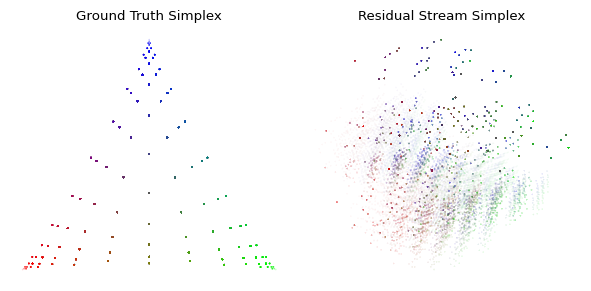

In [30]:
from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3



belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)

# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors =  transformer_input_belief_flattened.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plotting the true beliefs projected onto the simplex
axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes[0].axis('off')
axes[0].set_title("Ground Truth Simplex")

# Plotting the predicted beliefs projected onto the simplex
axes[1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.3, s=0.01)
axes[1].axis('off')
axes[1].set_title("Residual Stream Simplex")

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()